In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from random import randint
import matplotlib.pyplot as plt
import cv2

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('../input/labels.csv')
df_test = pd.read_csv('../input/sample_submission.csv')

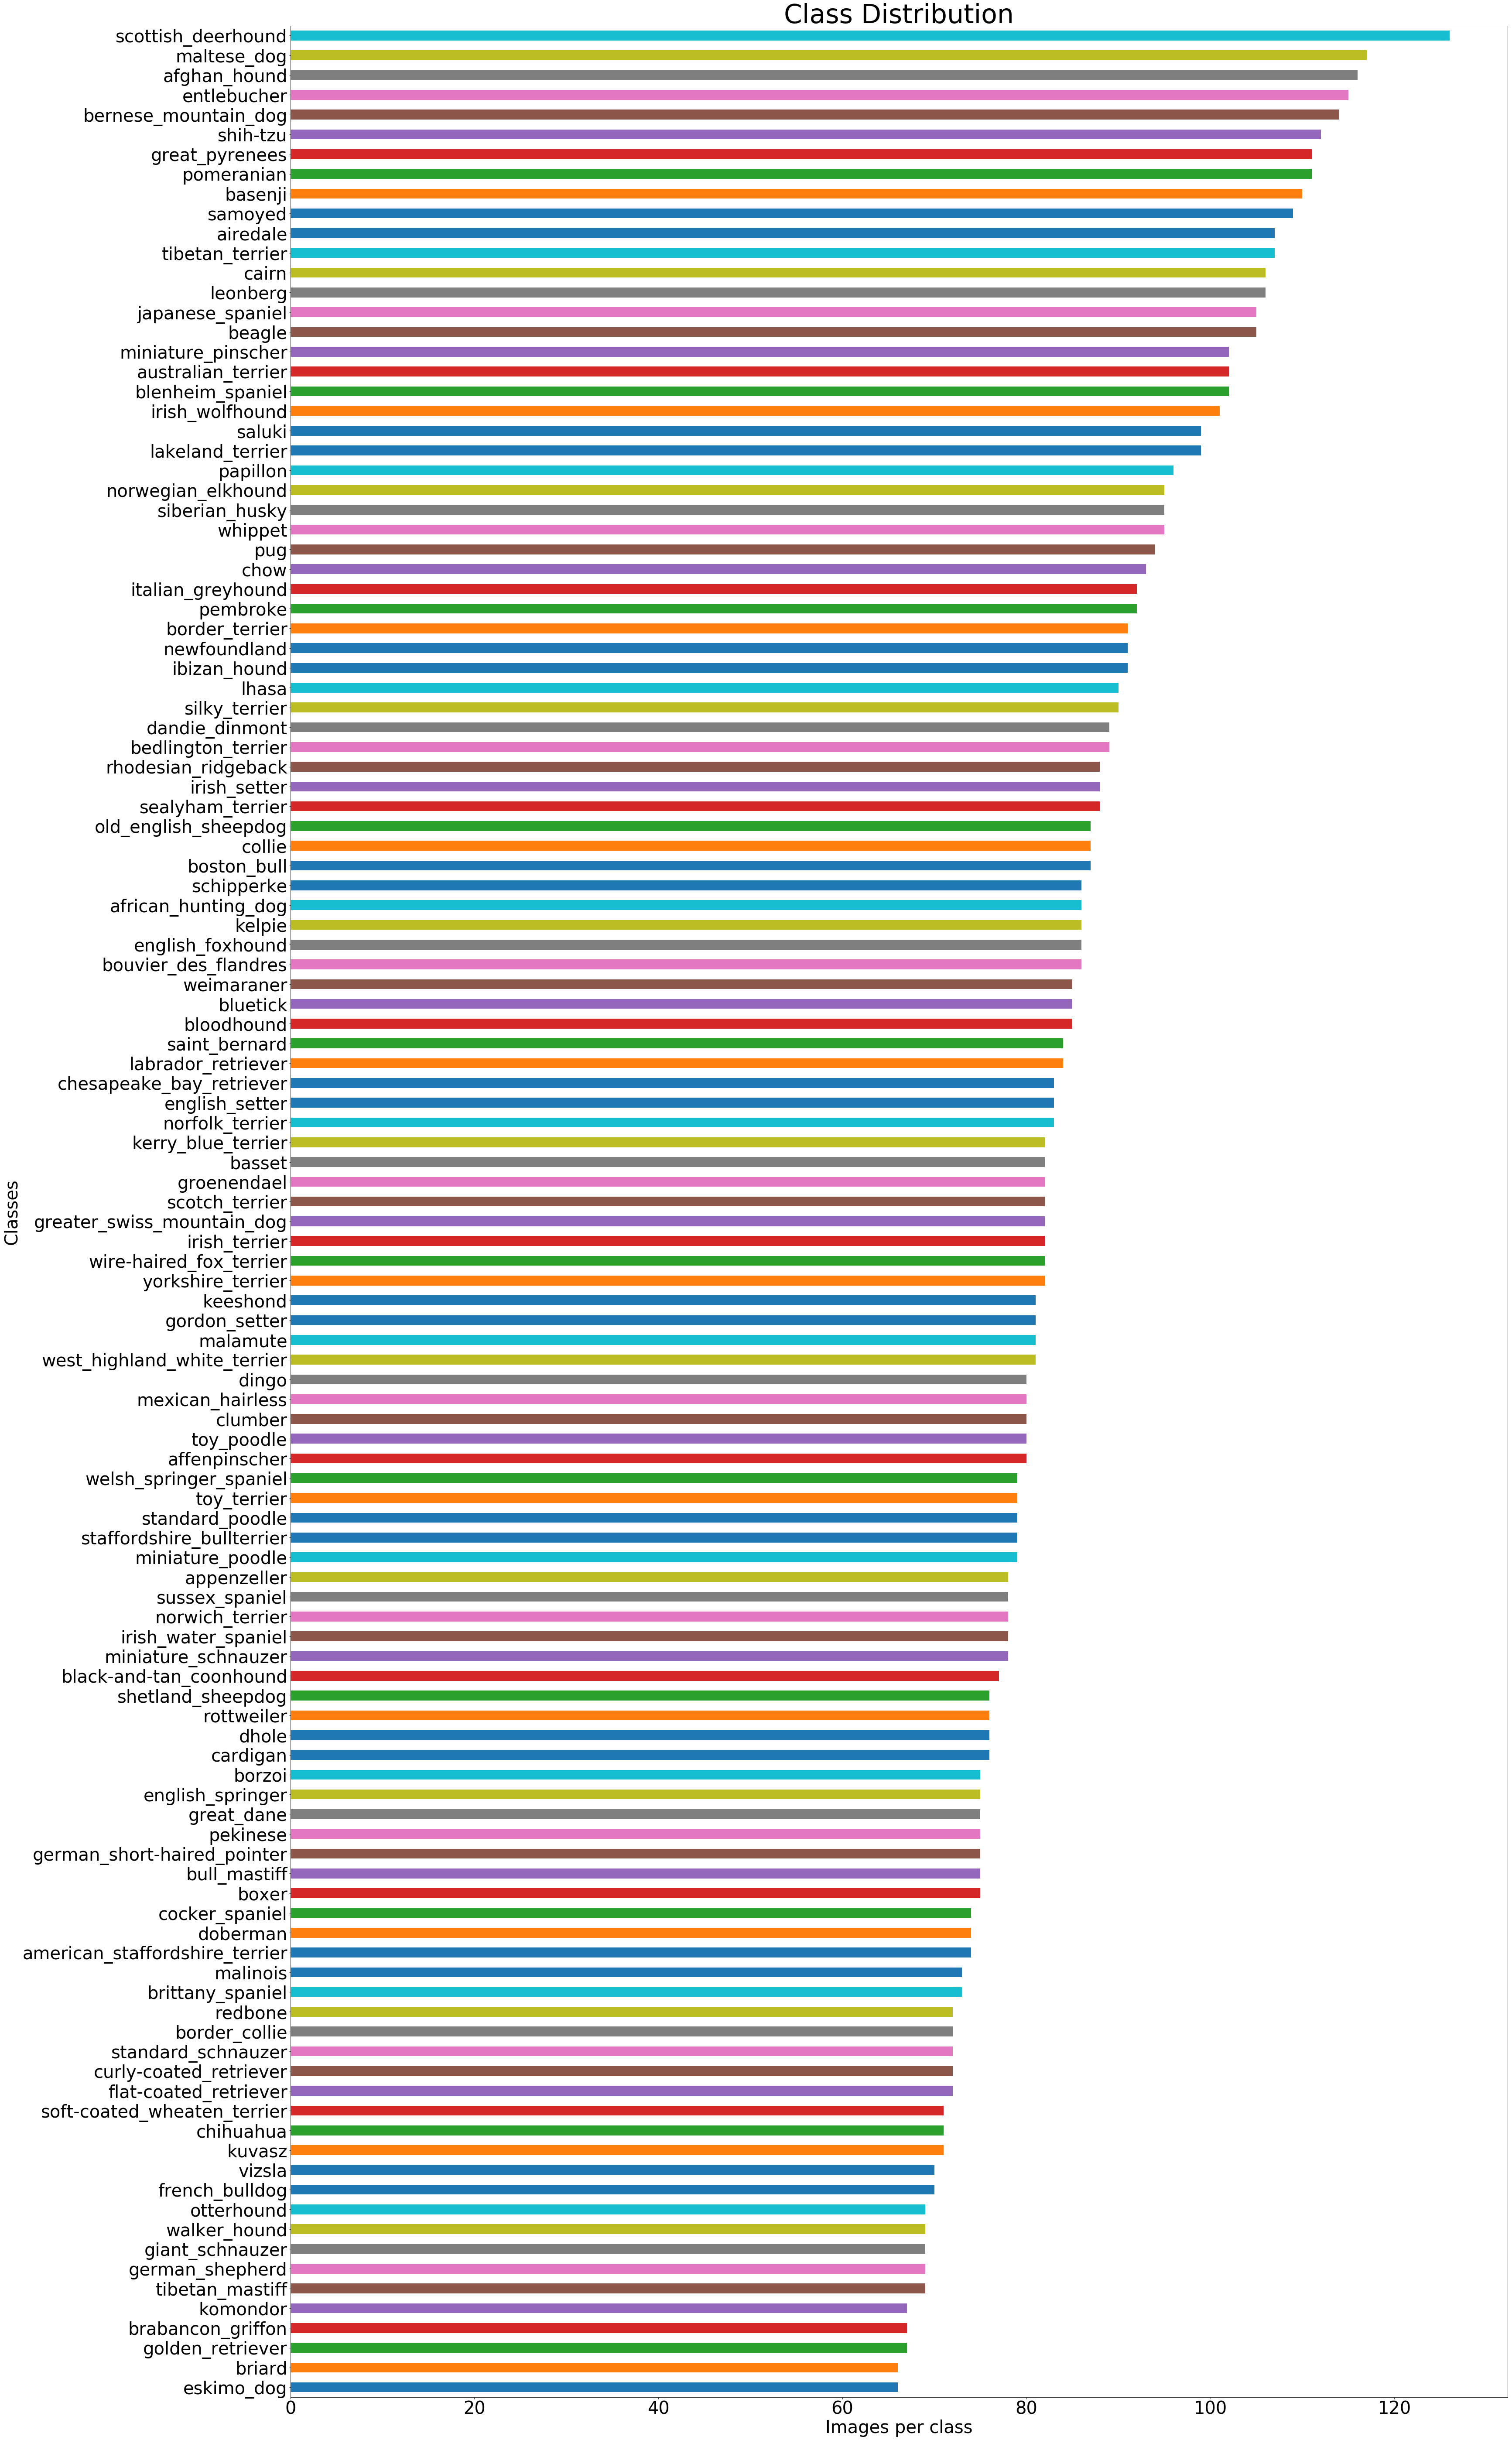

In [3]:
ax=pd.value_counts(df_train['breed'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Class Distribution",
                                                       figsize=(50,100))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)

In [4]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [5]:
one_hot_labels = np.asarray(one_hot)

In [6]:
def read_and_resize_images(df,nrow=224,ncol=224,channels=3):
    from scipy import misc
    i = 0
    x = []
    y = []
    breeds = []
    for f, breed in tqdm(df.values):
        img = misc.imread('../input/train/{}.jpg'.format(f))
        label = one_hot_labels[i]
        x.append(misc.imresize(img, (nrow, ncol,channels)))
        y.append(label)
        breeds.append(breed)
        i += 1
    return x,y,breeds

In [7]:
x_train,y_train,breeds_train = read_and_resize_images(df_train)

  0%|          | 0/10222 [00:00<?, ?it/s]C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 10222/10222 [01:20<00:00, 127.71it/s]


In [8]:
def read_and_resize_images_test(df,nrow=224,ncol=224,channels=3):
    from scipy import misc
    x = []
    for f in tqdm(df['id'].values):
        img = misc.imread('../input/test/{}.jpg'.format(f))
        x.append(misc.imresize(img, (nrow, ncol,channels)))
    return x

In [9]:
x_test = read_and_resize_images_test(df_test)

  0%|          | 0/10357 [00:00<?, ?it/s]C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
C:\Users\igor8\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
100%|██████████| 10357/10357 [02:35<00:00, 66.68it/s]


In [10]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

In [11]:
def plot_images(images, classes):
    assert len(images) == len(classes) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(60,60),sharex=True)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
   
    for i, ax in enumerate(axes.flat):
        # Plot image.
        
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB).reshape(224,224,3), cmap='hsv')    
        xlabel = "Breed: {0}".format(classes[i])
    
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        ax.xaxis.label.set_size(60)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    
    plt.show()

Images to show: 9
Classes to show: 9


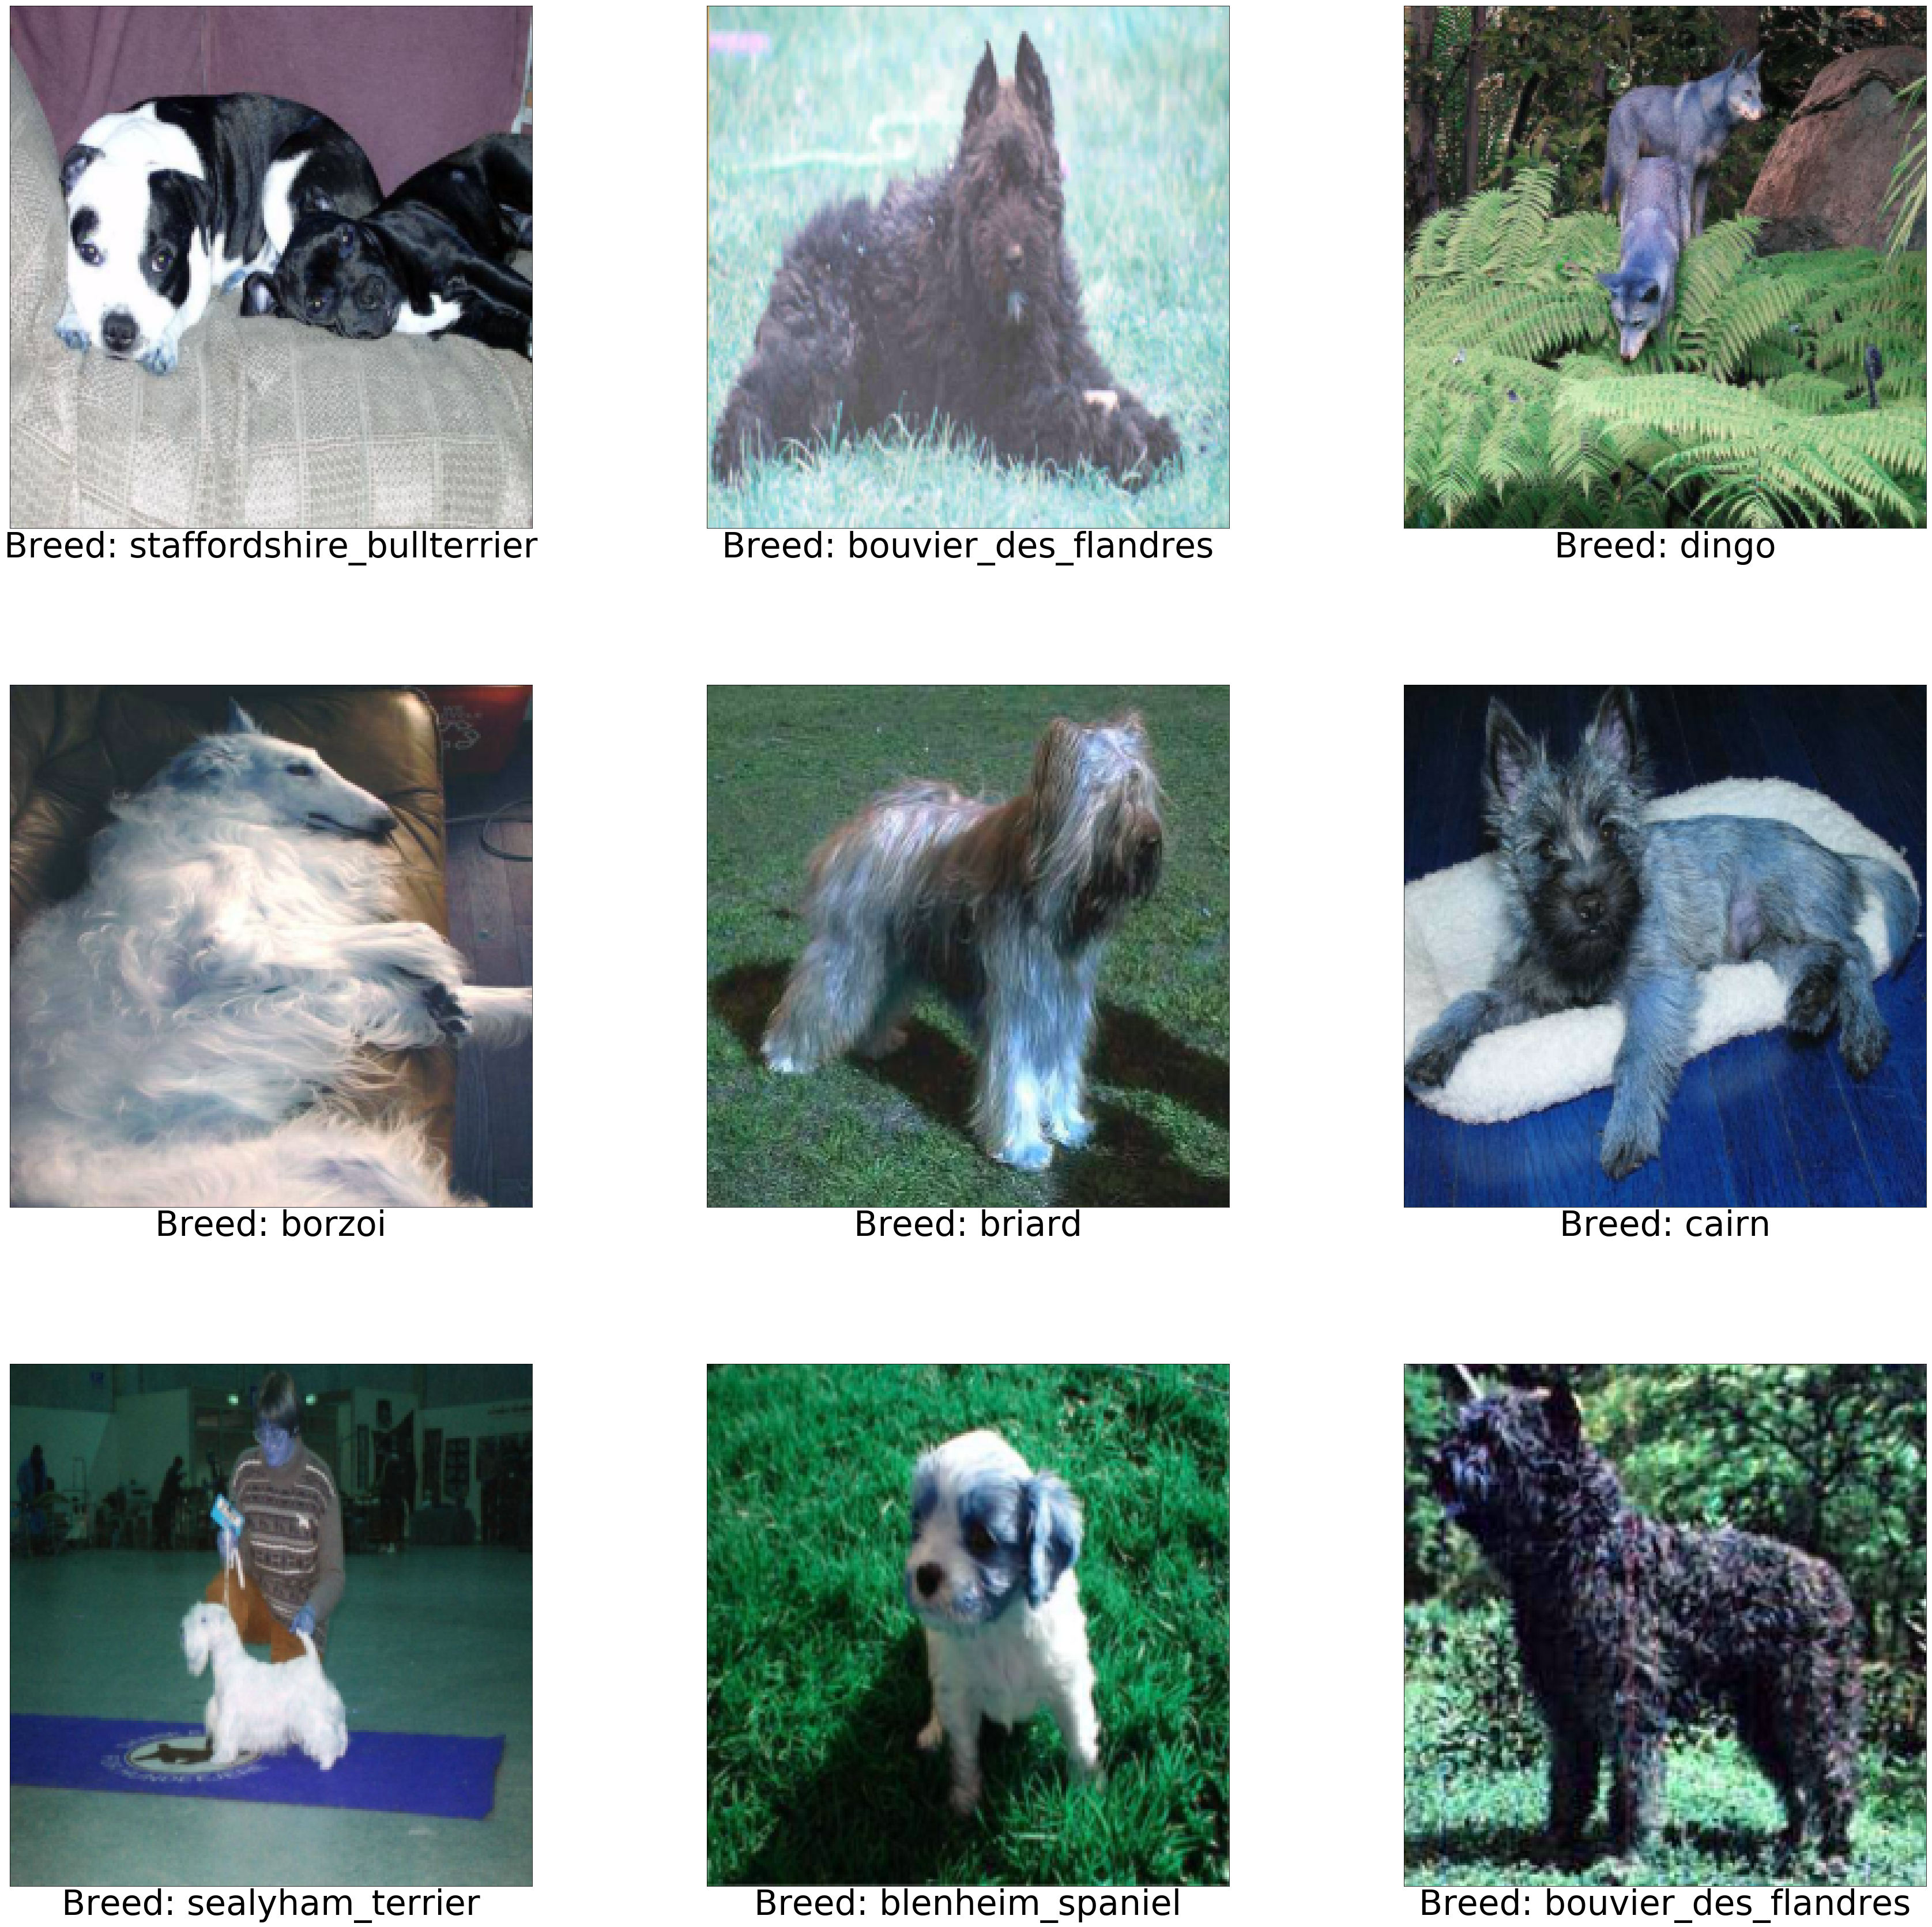

In [12]:

random_numbers = [randint(0, len(x_train)) for p in range(0,9)]
x_train_to_show = [x_train[i] for i in random_numbers]
breeds_train_to_show = [breeds_train[i] for i in random_numbers]
print("Images to show: {0}".format(len(x_train_to_show)))
print("Classes to show: {0}".format(len(breeds_train_to_show)))

plot_images(x_train_to_show, breeds_train_to_show)

In [13]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

(10222, 224, 224, 3)
(10222, 120)
(10357, 224, 224, 3)


In [6]:
num_class = y_train_raw.shape[1]

NameError: name 'y_train_raw' is not defined

In [15]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [4]:
def prepareModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [ ]:
firstModel = prepareModel(num_class)
firstModel.summary()

In [18]:
firstModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/1


6464/7155 [==========================>...] - ETA: 6:04:59 - loss: 4.7874 - acc: 0.0000e+ - ETA: 3:26:50 - loss: 4.7873 - acc: 0.0156   - ETA: 2:33:22 - loss: 4.7875 - acc: 0.01 - ETA: 2:06:05 - loss: 4.7877 - acc: 0.01 - ETA: 1:49:55 - loss: 4.7880 - acc: 0.01 - ETA: 1:38:40 - loss: 4.7877 - acc: 0.01 - ETA: 1:30:59 - loss: 4.7882 - acc: 0.01 - ETA: 1:24:57 - loss: 4.7880 - acc: 0.01 - ETA: 1:20:13 - loss: 4.7882 - acc: 0.01 - ETA: 1:16:29 - loss: 4.7878 - acc: 0.00 - ETA: 1:13:13 - loss: 4.7877 - acc: 0.00 - ETA: 1:10:42 - loss: 4.7875 - acc: 0.00 - ETA: 1:08:30 - loss: 4.7872 - acc: 0.00 - ETA: 1:06:34 - loss: 4.7869 - acc: 0.00 - ETA: 1:05:00 - loss: 4.7867 - acc: 0.00 - ETA: 1:03:28 - loss: 4.7866 - acc: 0.00 - ETA: 1:02:02 - loss: 4.7865 - acc: 0.00 - ETA: 1:00:48 - loss: 4.7865 - acc: 0.00 - ETA: 59:39 - loss: 4.7866 - acc: 0.0082 - ETA: 58:36 - loss: 4.7865 - acc: 0.00 - ETA: 57:43 - loss: 4.7859 - acc: 0.01 - ETA: 56:44 - loss: 4.7860 - acc: 0.00 - ETA: 55:56 - loss: 4.7856 - a

In [19]:
preds = firstModel.predict(x_test, verbose=1)

10357/10357 [==============================] - ETA: 1:09:0 - ETA: 1:09:2 - ETA: 1:09:2 - ETA: 1:09:1 - ETA: 1:08:2 - ETA: 1:08:0 - ETA: 1:07:5 - ETA: 1:07:5 - ETA: 1:07:3 - ETA: 1:07:1 - ETA: 1:06:5 - ETA: 1:06:4 - ETA: 1:06:3 - ETA: 1:06:2 - ETA: 1:06:0 - ETA: 1:05:4 - ETA: 1:05:3 - ETA: 1:05:2 - ETA: 1:05:1 - ETA: 1:04:5 - ETA: 1:04:4 - ETA: 1:04:2 - ETA: 1:04:2 - ETA: 1:04:0 - ETA: 1:03:5 - ETA: 1:03:3 - ETA: 1:03:2 - ETA: 1:03:1 - ETA: 1:02:5 - ETA: 1:02:4 - ETA: 1:02:3 - ETA: 1:02:1 - ETA: 1:02:0 - ETA: 1:01:5 - ETA: 1:01:3 - ETA: 1:01:2 - ETA: 1:01:1 - ETA: 1:01:0 - ETA: 1:00:4 - ETA: 1:00:3 - ETA: 1:00:2 - ETA: 1:00:1 - ETA: 59:59  - ETA: 59:5 - ETA: 59:4 - ETA: 59:2 - ETA: 59:1 - ETA: 59:0 - ETA: 58:5 - ETA: 58:4 - ETA: 58:3 - ETA: 58:1 - ETA: 58:0 - ETA: 57:5 - ETA: 57:4 - ETA: 57:2 - ETA: 57:1 - ETA: 56:5 - ETA: 56:4 - ETA: 56:3 - ETA: 56:2 - ETA: 56:0 - ETA: 55:5 - ETA: 55:4 - ETA: 55:3 - ETA: 55:1 - ETA: 55:0 - ETA: 54:5 - ETA: 54:3 - ETA: 54:2 - ETA: 54:1 - ETA: 53:5 - ETA

In [20]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008201,0.009499,0.008839,0.008989,0.007910,0.007979,0.008783,0.009668,0.008094,...,0.007918,0.007789,0.007522,0.007806,0.008262,0.008049,0.007899,0.008102,0.008151,0.007771
1,00102ee9d8eb90812350685311fe5890,0.008130,0.009674,0.008888,0.009060,0.007859,0.007898,0.008834,0.009829,0.008074,...,0.007889,0.007709,0.007430,0.007759,0.008280,0.008033,0.007894,0.008072,0.008137,0.007728
2,0012a730dfa437f5f3613fb75efcd4ce,0.008193,0.009410,0.008787,0.008927,0.007969,0.008038,0.008757,0.009564,0.008120,...,0.007945,0.007824,0.007578,0.007846,0.008256,0.008081,0.007960,0.008114,0.008150,0.007815
3,001510bc8570bbeee98c8d80c8a95ec1,0.008157,0.009702,0.008887,0.009056,0.007893,0.007927,0.008866,0.009836,0.008022,...,0.007903,0.007647,0.007421,0.007764,0.008265,0.008006,0.007854,0.008052,0.008074,0.007706
4,001a5f3114548acdefa3d4da05474c2e,0.008198,0.009595,0.008836,0.009010,0.007932,0.007980,0.008828,0.009713,0.008068,...,0.007918,0.007707,0.007479,0.007797,0.008256,0.008045,0.007879,0.008074,0.008113,0.007750


In [21]:
def prepareSecondModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers[:10]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [22]:
secondModel = prepareSecondModel(num_class)
secondModel.summary()
secondModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

6368/7155 [=========================>....] - ETA: 1:51:17 - loss: 4.7874 - acc: 0.0000e+ - ETA: 1:42:29 - loss: 6.9646 - acc: 0.0000e+ - ETA: 1:37:55 - loss: 6.2390 - acc: 0.0000e+ - ETA: 1:36:19 - loss: 5.8765 - acc: 0.0000e+ - ETA: 1:34:46 - loss: 5.6591 - acc: 0.0000e+ - ETA: 1:33:56 - loss: 5.5133 - acc: 0.0000e+ - ETA: 1:32:46 - loss: 5.4082 - acc: 0.0000e+ - ETA: 1:32:03 - loss: 5.3432 - acc: 0.0000e+ - ETA: 1:31:34 - loss: 5.2817 - acc: 0.0000e+ - ETA: 1:30:47 - loss: 5.2319 - acc: 0.0000e+ - ETA: 1:30:04 - loss: 5.1909 - acc: 0.0028   - ETA: 1:29:23 - loss: 5.1570 - acc: 0.00 - ETA: 1:28:48 - loss: 5.1285 - acc: 0.00 - ETA: 1:28:07 - loss: 5.1037 - acc: 0.00 - ETA: 1:27:38 - loss: 5.0824 - acc: 0.00 - ETA: 1:27:00 - loss: 5.0641 - acc: 0.00 - ETA: 1:26:31 - loss: 5.0478 - acc: 0.00 - ETA: 1:25:54 - loss: 5.0339 - acc: 0.00 - ETA: 1:25:40 - loss: 5.0209 - acc: 0.00 - ETA: 1:25:40 - loss: 5.0092 - acc: 0.00 - ETA: 1:25:26 - loss: 4.9982 - acc: 0.00 - ETA: 1:25:02 - loss: 4.9877 -

In [23]:
preds = secondModel.predict(x_test, verbose=1)

10357/10357 [==============================] - ETA: 1:14:4 - ETA: 1:14:3 - ETA: 1:13:5 - ETA: 1:12:2 - ETA: 1:11:5 - ETA: 1:11:5 - ETA: 1:11:3 - ETA: 1:11:1 - ETA: 1:11:0 - ETA: 1:10:3 - ETA: 1:10:2 - ETA: 1:10:1 - ETA: 1:09:5 - ETA: 1:09:4 - ETA: 1:09:3 - ETA: 1:09:2 - ETA: 1:09:0 - ETA: 1:08:4 - ETA: 1:08:3 - ETA: 1:08:2 - ETA: 1:08:1 - ETA: 1:08:0 - ETA: 1:08:0 - ETA: 1:07:5 - ETA: 1:07:4 - ETA: 1:07:3 - ETA: 1:07:2 - ETA: 1:07:1 - ETA: 1:07:1 - ETA: 1:07:1 - ETA: 1:06:5 - ETA: 1:06:4 - ETA: 1:06:2 - ETA: 1:06:0 - ETA: 1:05:5 - ETA: 1:05:3 - ETA: 1:05:2 - ETA: 1:05:0 - ETA: 1:04:5 - ETA: 1:04:3 - ETA: 1:04:2 - ETA: 1:04:0 - ETA: 1:03:5 - ETA: 1:03:3 - ETA: 1:03:2 - ETA: 1:03:0 - ETA: 1:02:5 - ETA: 1:02:3 - ETA: 1:02:2 - ETA: 1:02:1 - ETA: 1:01:5 - ETA: 1:01:4 - ETA: 1:01:2 - ETA: 1:01:2 - ETA: 1:01:1 - ETA: 1:01:0 - ETA: 1:01:0 - ETA: 1:00:4 - ETA: 1:00:4 - ETA: 1:00:3 - ETA: 1:00:1 - ETA: 1:00:1 - ETA: 1:00:1 - ETA: 1:00:1 - ETA: 1:00:0 - ETA: 59:58  - ETA: 59:4 - ETA: 59:3 - ETA: 

In [24]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008172,0.008769,0.008431,0.00851,0.008264,0.008156,0.008687,0.008748,0.008324,...,0.008229,0.008177,0.008093,0.008092,0.008414,0.008181,0.008192,0.008216,0.008153,0.008268
1,00102ee9d8eb90812350685311fe5890,0.008172,0.008769,0.008431,0.00851,0.008264,0.008156,0.008687,0.008748,0.008324,...,0.008229,0.008177,0.008093,0.008092,0.008414,0.008181,0.008192,0.008216,0.008153,0.008268
2,0012a730dfa437f5f3613fb75efcd4ce,0.008172,0.008769,0.008431,0.00851,0.008264,0.008156,0.008687,0.008748,0.008324,...,0.008229,0.008177,0.008093,0.008092,0.008414,0.008181,0.008192,0.008216,0.008153,0.008268
3,001510bc8570bbeee98c8d80c8a95ec1,0.008172,0.008769,0.008431,0.00851,0.008264,0.008156,0.008687,0.008748,0.008324,...,0.008229,0.008177,0.008093,0.008092,0.008414,0.008181,0.008192,0.008216,0.008153,0.008268
4,001a5f3114548acdefa3d4da05474c2e,0.008172,0.008769,0.008431,0.00851,0.008264,0.008156,0.008687,0.008748,0.008324,...,0.008229,0.008177,0.008093,0.008092,0.008414,0.008181,0.008192,0.008216,0.008153,0.008268


In [25]:
def prepareThirdModel(num_class):
    base_model = VGG19(#weights='imagenet',
        weights = None, include_top=False, input_shape=(224, 224, 3))

    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
        
    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, 
                  metrics=['accuracy'])

    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    return model

In [26]:
thirdModel = prepareThirdModel(num_class)
thirdModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
thirdModel.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/1


6336/7155 [=========================>....] - ETA: 1:45:54 - loss: 4.7874 - acc: 0.0000e+ - ETA: 1:39:09 - loss: 5.3742 - acc: 0.0000e+ - ETA: 1:35:49 - loss: 5.1790 - acc: 0.0000e+ - ETA: 1:33:59 - loss: 5.0812 - acc: 0.0000e+ - ETA: 1:32:34 - loss: 5.0223 - acc: 0.0063   - ETA: 1:32:49 - loss: 4.9823 - acc: 0.00 - ETA: 1:32:29 - loss: 4.9605 - acc: 0.00 - ETA: 1:31:42 - loss: 4.9417 - acc: 0.00 - ETA: 1:30:56 - loss: 4.9237 - acc: 0.00 - ETA: 1:30:08 - loss: 4.9102 - acc: 0.00 - ETA: 1:29:28 - loss: 4.8991 - acc: 0.00 - ETA: 1:28:39 - loss: 4.8897 - acc: 0.00 - ETA: 1:28:08 - loss: 4.8823 - acc: 0.00 - ETA: 1:27:26 - loss: 4.8755 - acc: 0.00 - ETA: 1:26:53 - loss: 4.8693 - acc: 0.00 - ETA: 1:26:16 - loss: 4.8643 - acc: 0.00 - ETA: 1:25:44 - loss: 4.8593 - acc: 0.00 - ETA: 1:25:12 - loss: 4.8559 - acc: 0.00 - ETA: 1:24:42 - loss: 4.8524 - acc: 0.00 - ETA: 1:24:09 - loss: 4.8489 - acc: 0.00 - ETA: 1:23:44 - loss: 4.8463 - acc: 0.00 - ETA: 1:23:11 - loss: 4.8438 - acc: 0.00 - ETA: 1:22:4

In [28]:
preds = thirdModel.predict(x_test, verbose=1)

10357/10357 [==============================] - ETA: 1:08:4 - ETA: 1:08:4 - ETA: 1:08:0 - ETA: 1:07:3 - ETA: 1:07:0 - ETA: 1:06:4 - ETA: 1:06:4 - ETA: 1:06:3 - ETA: 1:06:1 - ETA: 1:05:5 - ETA: 1:05:4 - ETA: 1:05:3 - ETA: 1:05:2 - ETA: 1:05:0 - ETA: 1:04:5 - ETA: 1:04:4 - ETA: 1:04:3 - ETA: 1:04:2 - ETA: 1:04:0 - ETA: 1:03:5 - ETA: 1:03:4 - ETA: 1:03:2 - ETA: 1:03:1 - ETA: 1:03:0 - ETA: 1:02:4 - ETA: 1:02:3 - ETA: 1:02:2 - ETA: 1:02:0 - ETA: 1:01:5 - ETA: 1:01:4 - ETA: 1:01:3 - ETA: 1:01:1 - ETA: 1:01:0 - ETA: 1:00:5 - ETA: 1:00:3 - ETA: 1:00:2 - ETA: 1:00:1 - ETA: 59:59  - ETA: 59:4 - ETA: 59:3 - ETA: 59:2 - ETA: 59:0 - ETA: 58:5 - ETA: 58:4 - ETA: 58:3 - ETA: 58:2 - ETA: 58:1 - ETA: 57:5 - ETA: 57:4 - ETA: 57:3 - ETA: 57:3 - ETA: 57:3 - ETA: 57:2 - ETA: 57:2 - ETA: 57:2 - ETA: 57:3 - ETA: 57:3 - ETA: 57:3 - ETA: 57:3 - ETA: 57:1 - ETA: 57:0 - ETA: 56:4 - ETA: 56:3 - ETA: 56:1 - ETA: 56:0 - ETA: 55:4 - ETA: 55:3 - ETA: 55:2 - ETA: 55:0 - ETA: 54:5 - ETA: 54:3 - ETA: 54:2 - ETA: 54:1 - E

In [29]:
sub = pd.DataFrame(preds)
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008156,0.009039,0.008471,0.008668,0.0081,0.008027,0.008969,0.009163,0.008362,...,0.008224,0.008139,0.007966,0.007962,0.008361,0.008013,0.008199,0.008286,0.008062,0.008026
1,00102ee9d8eb90812350685311fe5890,0.008156,0.009039,0.008471,0.008668,0.0081,0.008027,0.008969,0.009163,0.008362,...,0.008224,0.008139,0.007966,0.007962,0.008361,0.008013,0.008199,0.008286,0.008062,0.008026
2,0012a730dfa437f5f3613fb75efcd4ce,0.008156,0.009039,0.008471,0.008668,0.0081,0.008027,0.008969,0.009163,0.008362,...,0.008224,0.008139,0.007966,0.007962,0.008361,0.008013,0.008199,0.008286,0.008062,0.008026
3,001510bc8570bbeee98c8d80c8a95ec1,0.008156,0.009039,0.008471,0.008668,0.0081,0.008027,0.008969,0.009163,0.008362,...,0.008224,0.008139,0.007966,0.007962,0.008361,0.008013,0.008199,0.008286,0.008062,0.008026
4,001a5f3114548acdefa3d4da05474c2e,0.008156,0.009039,0.008471,0.008668,0.0081,0.008027,0.008969,0.009163,0.008362,...,0.008224,0.008139,0.007966,0.007962,0.008361,0.008013,0.008199,0.008286,0.008062,0.008026


In [2]:
import mlflow.keras
mlflow.keras.save_model(firstModel, '.')

Using TensorFlow backend.


NameError: name 'firstModel' is not defined